In [1]:
#### Load the libraries 

import os
import numpy as np
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option("display.max_rows", None, "display.max_columns", None)

# Data prep

## Oxford Economics data

File downloaded from Oxford Economics on 17th of June 2021
Last data Update date is 30th of April 2021

#### Load the file with GVA and Employment

In [2]:
# overall Greater London file
df = pd.read_excel('F:\\Research\\CommercialPrivate\\Central London\\DATA\\FORECASTS\\2021\\Q2 2021\\Greater London GVA and Employment - 17 June 2021 10_48_24.xlsx', 'Default')

# Westminster file
westm = pd.read_excel('F:\\Research\\CommercialPrivate\\Central London\\DATA\\FORECASTS\\2021\\Q2 2021\\Westminster GVA and Employment - 30 June 2021 15_29_52.xlsx', 'Default')
del westm['Databank']

In [3]:
df = df.append(westm, ignore_index=True)

#### Look at the data

In [4]:
#df.head()
#westm.head()

In [5]:
#df.dtypes

In [6]:
#list(df)

#### Reshape data

In [7]:
## Reshape 1: Turn years columns into one

df = pd.melt(df, id_vars=('Location',
 'Indicator',
 'Sector',
 'Units',
 'Scale',
 'Measurement',
 'Source',
 'Seasonally adjusted',
 'Base year price',
 'Base year index',
 'Historical end',
 'Date of last update',
 'Source details',
 'Additional source details',
 'Contact email',
 'Location code',
 'Indicator code')
  , var_name="year", value_name="value" )

In [8]:
#df

In [9]:
## Reshape 2: Make sectors as columns
## a lot of columns will have to go so that reshape is efficient
# reset index gets rid of the multilevel structure

df = pd.pivot_table(df, values='value', index=['Location',
 'Indicator',
 'Units',
 'Scale',
 'Measurement',
 'year'],
columns=['Sector']).reset_index()

In [10]:
#df

In [11]:
#list(df)

In [12]:
df["Aggr2"] = df['Real estate activities'] + df['Financial and insurance'] +  df['Professional, scientific and tech'] + df['Information and communication'] + df['Administrative and support']
df["Aggr3"] = df["Aggr2"] + df['Public administration and defence']  + df['Education']   
df["Aggr1"] = df["Aggr2"] - df['Information and communication'] 

In [13]:
#list(df)

In [14]:
df_aggr = df.iloc[:, [0,1,2,3,4,5, 10, 11, 15, 16, 17]]

In [15]:
#df_aggr

In [16]:
# looks like 'Office aggregate (incl. ICT)' is the same as Aggr2 
# and 'Office aggregate (excl. ICT)' is the same as Aggr1
# re-create df_aggr w/t these columns
df_aggr = df.iloc[:, [0,1,2,3,4,5, 15, 16, 17]]

In [17]:
#df_aggr
## Aggr 1 - excluding ICT
## Aggr 2 - including ICT
## Aggr 3 - including Public admistration and defence & Education

In [18]:
#list(df_aggr)

In [19]:
## Reshape 3: Turn Aggr columns into one
df_aggr = pd.melt(df_aggr, id_vars=('Location',
 'Indicator',
 'Units',
 'Scale',
 'Measurement',
 'year')
  , var_name="Aggr_version", value_name="value" )

In [20]:
# create future column names

df_aggr["Aggr_version"]  = df_aggr['Aggr_version'].str[-1:]
df_aggr["Indic_group"] = np.where(df_aggr['Indicator'] == "GVA by Sector", "GVA"+ df_aggr["Aggr_version"], "Employment"+ df_aggr["Aggr_version"]) 

In [21]:
#df_aggr

In [22]:
# Final Reshape
## Reshape 4: Turn Aggregate Indicators into columns

df_aggr = df_aggr.pivot_table( values='value', 
index=['year', 'Location'],
columns=['Indic_group']).reset_index()

In [23]:
df_aggr['year'] = df_aggr['year'].astype(int)

In [24]:
# Separate the two files

# Westmin
oxecon_westmin = df_aggr[df_aggr['Location']=='Westminster']
del oxecon_westmin['Location']
oxecon_westmin['Submarket'] ='West End'

# Overall Greater London
df_aggr = df_aggr[df_aggr['Location']=='Greater London']
del df_aggr['Location']

<ipython-input-24-6266e72cc04c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oxecon_westmin['Submarket'] ='West End'


In [25]:
# rename columns for the Westminster to have them as additional columns in the final files
oxecon_westmin=oxecon_westmin.rename(columns = {'Employment1':'Employment1_westmin', 'Employment2':'Employment2_westmin', 'Employment3':'Employment3_westmin', 'GVA1':'GVA1_westmin', 'GVA2':'GVA2_westmin', 'GVA3':'GVA3_westmin' })

In [26]:
#oxecon_westmin

#### Load the GDP Deflator file

In [27]:
defl = pd.read_excel('F:\\Research\\CommercialPrivate\\Central London\\DATA\\FORECASTS\\2021\\Q2 2021\\GDP deflator - 21 June 2021 11_11_10.xlsx', 'Default')

c:\users\sleptcom\appdata\local\programs\python\python39\lib\site-packages\openpyxl\styles\stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [28]:
# only keep relevant columns and rows
defl = defl[['Year','Level values']]
defl = defl[defl['Level values'] != "Level values"]

In [29]:
# rename columns
defl=defl.rename(columns = {'Level values':'GDP deflator', 'Year':'year'})

In [30]:
#defl

## PMA data

File obtained from PMA on 7th of June 2021. The data we are using is Prime rent and Stock series

#### Load the data on Prime Rents, Stock, Availability and Vacancy

In [31]:
rent = pd.read_excel('F:\\Research\\CommercialPrivate\\Central London\\DATA\\FORECASTS\\2021\\Q2 2021\\Central London fundamentals Jun 2021 - PMA.xls', 'PRIME RENTS - GBP PSF PA', skiprows = 9)

In [32]:
stock = pd.read_excel('F:\\Research\\CommercialPrivate\\Central London\\DATA\\FORECASTS\\2021\\Q2 2021\\Central London fundamentals Jun 2021 - PMA.xls', 'STOCK', skiprows = 9)

In [33]:
vacancy = pd.read_excel('F:\\Research\\CommercialPrivate\\Central London\\DATA\\FORECASTS\\2021\\Q2 2021\\Central London fundamentals Jun 2021 - PMA.xls', 'VACANCY', skiprows = 9)

In [34]:
avail = pd.read_excel('F:\\Research\\CommercialPrivate\\Central London\\DATA\\FORECASTS\\2021\\Q2 2021\\Central London fundamentals Jun 2021 - PMA.xls', 'AVAILABILITY', skiprows = 9)

#### Look at the data

In [35]:
avail.head()

,Market: Submarket,Country,Description,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,London: City,United Kingdom,"Availability (000s, sqft)",1461.75,2191.506,3195.505,4057.246,3535.85,2487.411,1189.666,2235.551,4253.575,7665.654,9577.085,10989.061,9818.315,6613.002,5969.014,5245.464,5738.921,4307.412,3433.065,4897.105,1489.568,4592.898,8645.434,10981.188,9434.060,6720.093,5116.452,6401.153,7935.537,8004.742,6837.285,7113.264,7144.351,6360.852,4029.591,4071.412,5376.152,5624.173,5283.393,5289.034,7152.989
1,London: West End,United Kingdom,"Availability (000s, sqft)",NaN,NaN,NaN,NaN,2570.00,2500.000,2110.000,1720.000,1650.000,2090.000,4362.869,6965.695,7747.141,6752.385,5724.892,4855.684,4430.267,2768.908,2839.993,2465.959,1578.875,4161.613,4663.511,5730.124,5194.651,3888.498,2866.620,2233.272,4358.400,4384.007,3924.110,3440.773,3612.603,3589.982,2944.852,2268.811,4170.819,3677.056,3725.455,2481.108,4136.457


In [36]:
#Append all the data together
pma = rent.append(stock, ignore_index=True)
pma = pma.append(vacancy, ignore_index=True)
pma = pma.append(avail, ignore_index=True)

In [37]:
#list(pma)
#pma

#### Reshape data

In [38]:
# Reshape 1: Turn years into 1 column
pma = pd.melt(pma, id_vars=('Market: Submarket','Country', 'Description',)
  , var_name="year", value_name="value" )

In [39]:
# Remove London from the submarket name
pma['Market: Submarket'] = pma['Market: Submarket'].str.split(': ').str[1]

# rename Submarket column
pma=pma.rename(columns = {'Market: Submarket':'Submarket'})

In [40]:
# Reshape 2: Turn Prime rent and Stock into columns

pma = pma.pivot_table(values='value', index=['year', 'Submarket'], columns=['Description']).reset_index()

In [41]:
# rename columns
pma=pma.rename(columns = {'Prime Rents (GBP, psf, pa)':'prime_rent', 'Stock (000s, sqft)':'stock', 'Vacancy (% of stock)':'vacancy', 'Availability (000s, sqft)':'availability' })

In [42]:
pma = pma.sort_values(by=['Submarket', 'year'])

## KF data

KF data we use is developemnt pipeline data - to forecast the stock

#### Load the data on Dev Pipeline

In [43]:
dev_pipe = pd.read_excel('F:\\Research\\CommercialPrivate\\Central London\\DATA\\FORECASTS\\2021\\Q2 2021\\London Development Pipeline Review and Viability Index - Landsec Additions.xlsx', 'London Dev. Pipeline', skiprows = [0,2,3])

c:\users\sleptcom\appdata\local\programs\python\python39\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [44]:
#dev_pipe

#### Slicing and aggregating the data

Slicing and aggregating the data to get the total pipeline values for City and West End submarkets

In [45]:
# drop the first empty column
dev_pipe = dev_pipe.drop('Unnamed: 0', 1)

In [46]:
list(dev_pipe)

['Address',
 'Developer / Equity',
 'Area',
 'Submarket',
 'Grade',
 'Total Development Size',
 'Pre-Let Size',
 'Under Offer Size',
 'Available \nSize',
 'Available + Under Offer Size',
 'Scheme Stage',
 'Spec or Pre-Let Intention',
 'Earliest Possible PC Date',
 'Earliest Possible PC Year',
 'Planning',
 'Finance',
 '3rd Party Rights',
 'VP',
 'Construction',
 'Overall',
 'Viability\nProbability',
 'KF Instruction',
 'KF Lead Contact',
 'Sq Ft Error Check',
 'Score Error Check']

In [47]:
# filter data - only keep records with high certainty (Overall 9 and 10)
# only keep records that will complete from 2021 onwards
dev_pipe = dev_pipe[(dev_pipe["Overall"]==9) | (dev_pipe["Overall"]==10)]
dev_pipe = dev_pipe[dev_pipe["Earliest Possible PC Year"]>2020]

In [48]:
# Select the records that are City in PMA definition - EC1, EC2, EC3, EC4 postcodes
dev_pipe["New_subm"] = np.where(dev_pipe['Address'].str.contains("EC1|EC2|EC3|EC4"),"City",dev_pipe["Submarket"]) 

In [49]:
# creating West End from West End Core, Fitzrovia, Soho, Victoria and Marylebone
dev_pipe["New_subm"] = np.where( ((dev_pipe['New_subm'] == "Victoria") | (dev_pipe['New_subm'] == "Soho") | (dev_pipe['New_subm'] == "Fitzrovia") | (dev_pipe['New_subm'] == "Marylebone") | (dev_pipe['New_subm'] == "West End Core")), "West End", dev_pipe["New_subm"] ) 

In [50]:
# only keep relevant columns
dev_pipe = dev_pipe[['New_subm','Total Development Size','Earliest Possible PC Year']]

In [51]:
# rename columns - Year and Submarket
dev_pipe=dev_pipe.rename(columns = {'Earliest Possible PC Year':'year', 'New_subm':'Submarket'})

In [52]:
# sum by submarket and year
dev_pipe = dev_pipe.groupby(['Submarket','year'])['Total Development Size'].sum().reset_index()

In [53]:
# keep only City and West End 
dev_pipe = dev_pipe[(dev_pipe['Submarket'] == "City") | (dev_pipe['Submarket'] == "West End") ]

In [54]:
dev_pipe

,Submarket,year,Total Development Size
11,City,2021.0,1838037
12,City,2022.0,2348062
13,City,2023.0,1894744
14,City,2024.0,424023
37,West End,2021.0,1235745
38,West End,2022.0,693233
39,West End,2023.0,444264
40,West End,2025.0,217000


## CoStar data

In [55]:
costar_city = pd.read_excel('F:\\Research\\CommercialPrivate\\Central London\\DATA\\FORECASTS\\2021\\Q2 2021\\CoStar Stock and Vacancy City - 22 June 2021.xlsx', 'DataExport')
costar_westend = pd.read_excel('F:\\Research\\CommercialPrivate\\Central London\\DATA\\FORECASTS\\2021\\Q2 2021\\CoStar Stock and Vacancy West End - 22 June 2021.xlsx', 'DataExport')

In [56]:
costar_city['Submarket'] = 'City'
costar_westend['Submarket'] = 'West End'

In [57]:
# append the datasets
costar = costar_city.append(costar_westend, ignore_index=True)
costar['year'] = costar['Period'].str[0:4].astype(int)
costar['stock_growth'] = costar.groupby(['Submarket'])['Inventory SF'].pct_change()
costar = costar[['year', 'Submarket' ,'stock_growth', 'Vacancy Rate', 'Inventory SF']]
costar=costar.rename(columns = {'Inventory SF':'stock_costar'})

In [58]:
#costar_westend

## Merging the datasets

In [59]:
# merge PMA Rent and Stock Data and GDP deflator
pma_and_defl  = pd.merge(pma, defl, on='year', how = 'right') # this will create empty rows

In [60]:
pma_and_defl["Submarket"] = np.where(pma_and_defl['year']>2020,"City",pma_and_defl["Submarket"])  # replace existing empty rows with City

In [61]:
# create duplicate rows and replace for West End
dupl = pma_and_defl.iloc[82:88].copy()
dupl.columns = pma_and_defl.columns
dupl["Submarket"] = "West End"
#print(dupl)

In [62]:
# append to the original
pma_and_defl = pma_and_defl.append(dupl, ignore_index=True)
#pma_and_defl

In [63]:
# add OE data on Employment and GVA
pma_and_defl_and_OE =  pd.merge(pma_and_defl, df_aggr, on='year')

In [64]:
# add Dev Pipeline
pma_and_defl_and_OE_and_devpipe =  pd.merge(pma_and_defl_and_OE, dev_pipe, on=['year', 'Submarket'], how = 'left')

In [65]:
# Add Wesyminster columns
pma_and_defl_and_OE_and_devpipe = pd.merge(pma_and_defl_and_OE_and_devpipe, oxecon_westmin, on=['year', 'Submarket'], how = 'left')
pma_and_defl_and_OE_and_devpipe

,year,Submarket,availability,prime_rent,stock,vacancy,GDP deflator,Employment1,Employment2,Employment3,GVA1,GVA2,GVA3,Total Development Size,Employment1_westmin,Employment2_westmin,Employment3_westmin,GVA1_westmin,GVA2_westmin,GVA3_westmin
0,1980.0,City,1461.750,23.06,42481.407,3.440917,27.80414,804.8280,1033.1270,1640.2770,46427.63,57322.63,103506.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1980.0,West End,NaN,20.00,50169.255,3.500000,27.80414,804.8280,1033.1270,1640.2770,46427.63,57322.63,103506.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1981.0,City,2191.506,25.16,43750.482,5.009101,31.23171,796.7573,1018.3363,1607.0943,44491.60,55009.10,97539.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1981.0,West End,NaN,23.10,50379.365,4.000000,31.23171,796.7573,1018.3363,1607.0943,44491.60,55009.10,97539.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1982.0,City,3195.505,27.26,45211.730,7.067867,33.73242,802.1086,1020.8456,1600.6086,43482.97,53313.40,92259.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1982.0,West End,NaN,25.00,50589.476,4.500000,33.73242,802.1086,1020.8456,1600.6086,43482.97,53313.40,92259.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1983.0,City,4057.246,31.45,46169.660,8.787689,35.60236,831.9567,1049.1757,1626.7017,44962.51,54827.45,92688.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1983.0,West End,NaN,25.00,50799.587,5.500000,35.60236,831.9567,1049.1757,1626.7017,44962.51,54827.45,92688.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1984.0,City,3535.850,32.50,46819.103,7.552152,37.46053,870.9718,1092.3988,1668.6758,47307.42,57515.32,94764.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1984.0,West End,2570.000,25.00,51385.692,5.001392,37.46053,870.9718,1092.3988,1668.6758,47307.42,57515.32,94764.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Creating forecast for stock

In [66]:
final =  pma_and_defl_and_OE_and_devpipe.copy()

In [67]:
# Add demolitions column based on PMA's advice - 1200 for West End and 1300 for City
final['Demolitions'] = 1200
final['Demolitions'] = np.where(final['Submarket'] =='City',1300,final['Demolitions']) 
final['Demolitions'] = np.where(final['year'] <2021 ,0,final['Demolitions'] ) 

In [68]:
# divide the Development number by 1000 so that all stock is in the same units
# replace NAs with zeros so that the summing works

final['Total Development Size'] = final['Total Development Size']/1000
final['Total Development Size'] = final['Total Development Size'].fillna(0)

In [69]:
# create Stock forecast
final = final.sort_values(by=['Submarket', 'year'])

In [70]:
final['stock'] = final.groupby(['Submarket'])['stock'].fillna(method='ffill') #fill stock values forward
final['Cum_Demol'] = final.groupby(['Submarket'])['Demolitions'].cumsum() # create running total of Demolitions
final['Cum_Devel'] = final.groupby(['Submarket'])['Total Development Size'].cumsum() # create running total of Developments

In [71]:
# calculate future stock
final['stock'] = np.where(final['year'] >2020,final['stock']+final['Cum_Devel']-final['Cum_Demol'],final['stock'] ) 
#final

In [72]:
# add CoStar stock growth and vacancy
final =  pd.merge(final, costar, on=['year', 'Submarket'], how = 'left')

In [73]:
# create alternative stock using CoStar stock growth rate
final['stock2'] = np.where(final['year'] >2020,final['stock'].shift(1)*(1+final['stock_growth']),final['stock']) 

In [74]:
# keep only relevant columns

In [75]:
final = final.drop(['Cum_Devel', 'Cum_Demol', 'Demolitions','Total Development Size', 'stock_growth'], axis=1)
#final

# Estimation starts

final is the result of the Data Prep

For the three Employment and GVA options:

Aggr 1 - excluding ICT;
Aggr 2 - including ICT;
Aggr 3 - including Public admistration and defence & Education

For the two Stock options
Stock - PMA stock , with forecast values created based on KF dev pipeline and average demolitions
Stock2 - PMA stock, with forecast values created using similar CoStar submarket stock growth

#### Transforming the variables

In [76]:
#get the row of year 2021
print(final[final['year']==2021].index.values)
final.iloc[41,4]

[41 88]


71203.709

In [77]:
# Deflate the nominal rent - to create real rent
final['real_rent'] = final['prime_rent'] /final.iloc[41,4]*100

In [78]:
#final

In [79]:
# take logarithms of vars
logged_vars = np.log(final[['stock','stock2','stock_costar','prime_rent','real_rent','availability','vacancy','Employment1','Employment2','Employment3', 'GVA1', 'GVA2', 'GVA3','Employment1_westmin','Employment2_westmin','Employment3_westmin', 'GVA1_westmin', 'GVA2_westmin', 'GVA3_westmin']])
#add prefix to var names
logged_vars = logged_vars.add_prefix('ln_')

In [80]:
# add logged vars back to the dataset
final = pd.concat([final, logged_vars], axis=1)

In [81]:
# split into City and West End
city = final[final['Submarket']=='City']
westend = final[final['Submarket']=='West End']

In [82]:
#westend

#### Testing variables for the presence of unit root

In [83]:
from statsmodels.tsa import stattools
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller

<AxesSubplot:xlabel='year'>

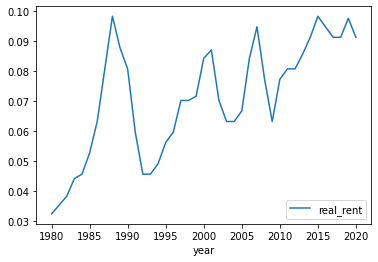

In [84]:
# Plot the series to understand how to best specify the ADF test (time trend or no time trend)
city.plot(x='year', y='real_rent')

In [85]:
# copied and modified the function for ADF test from the official documentation
# added the regression specification and the line on actual decision
# depending on the above plot, comment out or keep the line with "regression"

def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC'
                      #, regression='ct'
                     )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    print ('We cannot reject (the null) that there is a unit root, the series are non-stationary' if dfoutput['p-value']>0.05 else 'The null (there is a unit root) is rejected, no unit root, the series is stationary')

In [86]:
# apply adf test function to the series of choice. The null is that there IS a unit root
# 0:41 is to specify hist values

adf_test(city['real_rent'].iloc[0:41].values)

Results of Dickey-Fuller Test:
Test Statistic                  1.178503
p-value                         0.995834
#Lags Used                     10.000000
Number of Observations Used    30.000000
Critical Value (1%)            -3.669920
Critical Value (5%)            -2.964071
Critical Value (10%)           -2.621171
dtype: float64
We cannot reject (the null) that there is a unit root, the series are non-stationary


#### Long-run models

<AxesSubplot:label='55ce1bde-7ff2-4ded-b790-a139cb6375f7'>

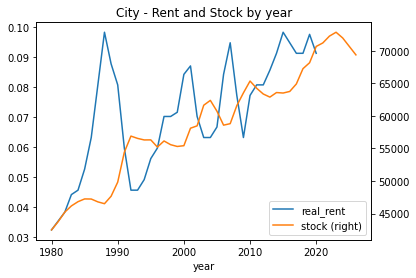

In [87]:
# Plot double axis plots to see the relationship between vars 
# this one is for City

rent_plot = city.plot(x='year', y='real_rent')
city.plot(x='year', y='stock',secondary_y=True, ax=rent_plot, title = 'City - Rent and Stock by year')

In [88]:
# Long run City
long_run_city = sm.OLS.from_formula(formula='ln_real_rent ~ ln_stock2 +ln_Employment1',data = city).fit()
print(long_run_city.summary())

                            OLS Regression Results                            
Dep. Variable:           ln_real_rent   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     63.74
Date:                Thu, 01 Jul 2021   Prob (F-statistic):           7.24e-13
Time:                        09:53:30   Log-Likelihood:                 21.676
No. Observations:                  41   AIC:                            -37.35
Df Residuals:                      38   BIC:                            -32.21
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          6.7800      3.529      1.

<AxesSubplot:label='edc88a3f-e783-44bc-ac25-2326ac7db24c'>

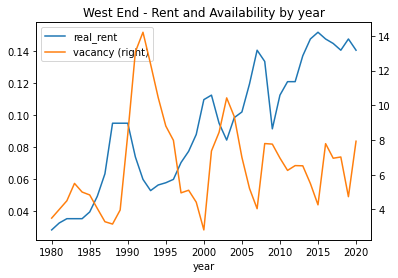

In [107]:
# Plot West End

rent_plot = westend.plot(x='year', y='real_rent')
westend.plot(x='year', y='availability',secondary_y=True, ax=rent_plot, title = 'West End - Rent and Availability by year')

In [106]:
# Long run West End

# In a set up with Availability, when demand is proxied via Employment, the Availability is insignificant
# when demand is proxed via GVA, with GVA1 and GVA2 - significant at 5%, with GVA3 - at 10 %
# with GVA1 the Adj R2 is slightly larger - 0.823 vs 0.820 in the model with GVA2

# when stock is used as a supply variable, the sign is positive.

long_run_westend = sm.OLS.from_formula(formula='ln_real_rent ~ ln_availability +ln_GVA1',data = westend).fit()
print(long_run_westend.summary())

                            OLS Regression Results                            
Dep. Variable:           ln_real_rent   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     84.26
Date:                Thu, 01 Jul 2021   Prob (F-statistic):           1.07e-14
Time:                        10:00:02   Log-Likelihood:                 5.9983
No. Observations:                  41   AIC:                            -5.997
Df Residuals:                      38   BIC:                           -0.8558
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -18.5236      1.236    -14.

In [93]:
westend

,year,Submarket,availability,prime_rent,stock,vacancy,GDP deflator,Employment1,Employment2,Employment3,GVA1,GVA2,GVA3,Employment1_westmin,Employment2_westmin,Employment3_westmin,GVA1_westmin,GVA2_westmin,GVA3_westmin,Vacancy Rate,stock_costar,stock2,real_rent,ln_stock,ln_stock2,ln_stock_costar,ln_prime_rent,ln_real_rent,ln_availability,ln_vacancy,ln_Employment1,ln_Employment2,ln_Employment3,ln_GVA1,ln_GVA2,ln_GVA3,ln_Employment1_westmin,ln_Employment2_westmin,ln_Employment3_westmin,ln_GVA1_westmin,ln_GVA2_westmin,ln_GVA3_westmin
47,1980.0,West End,NaN,20.0,50169.255,3.500000,27.80414,804.8280,1033.1270,1640.2770,46427.63,57322.63,103506.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50169.255000,0.028088,10.823158,10.823158,NaN,2.995732,-3.572398,NaN,1.252763,6.690629,6.940345,7.402620,10.745650,10.956451,11.547394,NaN,NaN,NaN,NaN,NaN,NaN
48,1981.0,West End,NaN,23.1,50379.365,4.000000,31.23171,796.7573,1018.3363,1607.0943,44491.60,55009.10,97539.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50379.365000,0.032442,10.827337,10.827337,NaN,3.139833,-3.428297,NaN,1.386294,6.680550,6.925925,7.382183,10.703056,10.915254,11.488014,NaN,NaN,NaN,NaN,NaN,NaN
49,1982.0,West End,NaN,25.0,50589.476,4.500000,33.73242,802.1086,1020.8456,1600.6086,43482.97,53313.40,92259.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50589.476000,0.035111,10.831499,10.831499,NaN,3.218876,-3.349254,NaN,1.504077,6.687244,6.928387,7.378139,10.680125,10.883943,11.432364,NaN,NaN,NaN,NaN,NaN,NaN
50,1983.0,West End,NaN,25.0,50799.587,5.500000,35.60236,831.9567,1049.1757,1626.7017,44962.51,54827.45,92688.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50799.587000,0.035111,10.835644,10.835644,NaN,3.218876,-3.349254,NaN,1.704748,6.723780,6.955760,7.394310,10.713584,10.911946,11.437005,NaN,NaN,NaN,NaN,NaN,NaN
51,1984.0,West End,2570.000,25.0,51385.692,5.001392,37.46053,870.9718,1092.3988,1668.6758,47307.42,57515.32,94764.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51385.692000,0.035111,10.847115,10.847115,NaN,3.218876,-3.349254,7.851661,1.609716,6.769610,6.996131,7.419786,10.764422,10.959807,11.459155,NaN,NaN,NaN,NaN,NaN,NaN
52,1985.0,West End,2500.000,28.0,51717.682,4.833937,39.47756,906.1304,1129.8064,1701.3804,51484.67,62181.87,99439.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51717.682000,0.039324,10.853555,10.853555,NaN,3.332205,-3.235925,7.824046,1.575661,6.809183,7.029802,7.439195,10.849039,11.037819,11.507305,NaN,NaN,NaN,NaN,NaN,NaN
53,1986.0,West End,2110.000,35.0,52037.375,4.054778,41.24808,939.2348,1160.9668,1732.7698,55986.37,67163.17,104436.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52037.375000,0.049155,10.859717,10.859717,NaN,3.555348,-3.012782,7.654443,1.399896,6.845066,7.057008,7.457476,10.932864,11.114880,11.556337,NaN,NaN,NaN,NaN,NaN,NaN
54,1987.0,West End,1720.000,45.0,52242.125,3.292362,43.46762,992.3621,1218.3411,1797.7581,60208.63,71942.13,108555.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52242.125000,0.063199,10.863644,10.863644,NaN,3.806662,-2.761468,7.450080,1.191605,6.900088,7.105245,7.494296,11.005571,11.183617,11.595018,NaN,NaN,NaN,NaN,NaN,NaN
55,1988.0,West End,1650.000,67.5,52270.301,3.156668,46.04146,1051.5366,1282.9466,1866.9326,64934.66,76983.36,113472.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52270.301000,0.094798,10.864184,10.864184,NaN,4.212128,-2.356002,7.408531,1.149517,6.958008,7.156915,7.532052,11.081137,11.251345,11.639312,NaN,NaN,NaN,NaN,NaN,NaN
56,1989.0,West End,2090.000,67.5,52718.095,3.964483,49.65364,1079.6590,1314.0430,1887.4760,67901.16,80651.86,116472.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52718.095000,0.094798,10.872714,10.872714,NaN,4.212128,-2.356002,7.644919,1.377375,6.984401,7.180864,7.542996,11.125808,11.297897,11.665411,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
#westend.to_csv('G:\\29 Data Analytics\\Commercial research projects\\MS\\CL office rents\\westend.csv')